# 5D HOSVD Analysis: [Ny, Nx, n_species, n_time, n_Re]

This notebook performs HOSVD on a 5-dimensional tensor including Reynolds number as a dimension.

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import tucker
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.tenalg import mode_dot, multi_mode_dot
import kagglehub
import h5py
from tqdm import tqdm
import pandas as pd
import kagglehub
import global_variables

In [2]:
# Configuration
n_snapshots = 200
subsample_x = 10
subsample_y = 10

# Load data for multiple Reynolds numbers
reynolds_numbers = [7000, 8000, 9000, 10000]
paths = [f"sharmapushan/hydrogen-jet-{re}" for re in reynolds_numbers]

component_names = global_variables.component_names
n_species = global_variables.n_species
molar_masses = global_variables.molar_masses
file_key_map = global_variables.file_key_map
Lx, Ly = global_variables.Lx, global_variables.Ly

print(f"Loading {len(reynolds_numbers)} Reynolds numbers: {reynolds_numbers}")

Loading 4 Reynolds numbers: [7000, 8000, 9000, 10000]


In [3]:
# Download datasets
data_paths = [kagglehub.dataset_download(name) for name in paths]

# Get metadata from first dataset to determine dimensions
with open(data_paths[0] + '/info.json') as f:
    metadata_template = json.load(f)

Nx, Ny = metadata_template['global']['Nxyz']
Nx_sub = Nx // subsample_x
Ny_sub = Ny // subsample_y

print(f"Spatial dimensions: Ny_sub={Ny_sub}, Nx_sub={Nx_sub}")
print(f"Chemical species: {n_species}")
print(f"Temporal snapshots: {n_snapshots}")
print(f"Reynolds numbers: {len(reynolds_numbers)}")

Spatial dimensions: Ny_sub=200, Nx_sub=160
Chemical species: 8
Temporal snapshots: 200
Reynolds numbers: 4


In [4]:
# Load all datasets into individual tensors
tensors_by_re = {}

for re_num, data_path in zip(reynolds_numbers, data_paths):
    print(f"\nLoading Re={re_num} from {data_path}")
    
    with open(data_path + '/info.json') as f:
        metadata = json.load(f)
    
    tensor = np.zeros((Ny_sub, Nx_sub, n_species, n_snapshots))
    
    for t_idx in tqdm(range(n_snapshots), desc=f"Re {re_num}"):
        for new_idx, (comp_name, orig_idx) in enumerate(zip(component_names, range(n_species))):
            filename_key = file_key_map[comp_name]
            filename = metadata['local'][t_idx][filename_key]
            data = np.fromfile(f"{data_path}/{filename}", dtype='<f4').reshape(Ny, Nx)
            molar_data = data / molar_masses[comp_name]
            tensor[:, :, new_idx, t_idx] = molar_data[::subsample_y, ::subsample_x]
    
    tensors_by_re[re_num] = tensor
    print(f"Loaded tensor shape: {tensor.shape}")

print("\nAll datasets loaded successfully!")


Loading Re=7000 from /home/isaccof/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-7000/versions/3


Re 7000: 100%|██████████| 200/200 [00:22<00:00,  9.09it/s]


Loaded tensor shape: (200, 160, 8, 200)

Loading Re=8000 from /home/isaccof/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3


Re 8000: 100%|██████████| 200/200 [00:04<00:00, 43.05it/s]


Loaded tensor shape: (200, 160, 8, 200)

Loading Re=9000 from /home/isaccof/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-9000/versions/2


Re 9000: 100%|██████████| 200/200 [00:25<00:00,  7.94it/s]


Loaded tensor shape: (200, 160, 8, 200)

Loading Re=10000 from /home/isaccof/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-10000/versions/2


Re 10000: 100%|██████████| 200/200 [00:24<00:00,  8.17it/s]

Loaded tensor shape: (200, 160, 8, 200)

All datasets loaded successfully!


In [5]:
# Construct 5D tensor: [Ny, Nx, n_species, n_time, n_Re]
n_Re = len(reynolds_numbers)
tensor_5d = np.zeros((Ny_sub, Nx_sub, n_species, n_snapshots, n_Re))

for re_idx, re_num in enumerate(reynolds_numbers):
    tensor_5d[:, :, :, :, re_idx] = tensors_by_re[re_num]

print(f"5D tensor shape: {tensor_5d.shape}")
print(f"Dimensions: (Ny={tensor_5d.shape[0]}, Nx={tensor_5d.shape[1]}, n_species={tensor_5d.shape[2]}, n_time={tensor_5d.shape[3]}, n_Re={tensor_5d.shape[4]})")

5D tensor shape: (200, 160, 8, 200, 4)
Dimensions: (Ny=200, Nx=160, n_species=8, n_time=200, n_Re=4)


In [6]:
def scale_and_center_5d_tensor(tensor, component_names, log_scale=True, std_scale=True, epsilon=1e-12):
    """
    Scale and center a 5D tensor [Ny, Nx, n_species, n_time, n_Re]
    Scaling is done per species across all spatial, temporal, and Reynolds dimensions
    """
    tensor_scaled = tensor.copy()
    
    for c_idx, comp_name in enumerate(component_names):
        # Extract all data for this species
        component_data = tensor_scaled[:, :, c_idx, :, :]
        
        if log_scale:
            component_data = np.log10(np.maximum(component_data, epsilon))
        
        # Compute statistics across all dimensions for this species
        mean_val = component_data.mean()
        std_val = component_data.std()
        
        if std_val < epsilon:
            std_val = epsilon  # prevent divide-by-zero
        
        if not std_scale:
            std_val = 1.0
        
        component_data_scaled = (component_data - mean_val) / std_val
        tensor_scaled[:, :, c_idx, :, :] = component_data_scaled
        
        print(f"Species {comp_name}: mean={mean_val:.3f}, std={std_val:.3f}")
    
    return tensor_scaled

In [7]:
# Apply standard scaling to 5D tensor
print("Applying standard scaling...")
tensor_5d_scaled = scale_and_center_5d_tensor(tensor_5d, component_names, log_scale=True, std_scale=True)
print(f"\nScaled 5D tensor shape: {tensor_5d_scaled.shape}")

Applying standard scaling...
Species YH: mean=-9.282, std=3.759
Species YH2: mean=-7.807, std=4.381
Species YO: mean=-9.436, std=3.325
Species YO2: mean=-2.298, std=0.980
Species YOH: mean=-9.283, std=3.489
Species YH2O: mean=-8.725, std=4.288
Species YHO2: mean=-10.015, std=2.579
Species YH2O2: mean=-10.650, std=1.965

Scaled 5D tensor shape: (200, 160, 8, 200, 4)


In [8]:
# Perform HOSVD on 5D tensor
print("\n" + "="*100)
print("Performing HOSVD on 5D tensor")
print("="*100)
print(f"Tensor shape: (Ny={tensor_5d_scaled.shape[0]}, Nx={tensor_5d_scaled.shape[1]}, n_species={tensor_5d_scaled.shape[2]}, n_time={tensor_5d_scaled.shape[3]}, n_Re={tensor_5d_scaled.shape[4]})")

# Compute factor matrices for each mode
print("\nComputing U_y (mode 0: spatial Y)...")
U_y, _, _ = np.linalg.svd(tl.unfold(tensor_5d_scaled, mode=0), full_matrices=False)

print("Computing U_x (mode 1: spatial X)...")
U_x, _, _ = np.linalg.svd(tl.unfold(tensor_5d_scaled, mode=1), full_matrices=False)

print("Computing U_chem (mode 2: chemical species)...")
U_chem, _, _ = np.linalg.svd(tl.unfold(tensor_5d_scaled, mode=2), full_matrices=False)

print("Computing U_time (mode 3: temporal)...")
U_time, _, _ = np.linalg.svd(tl.unfold(tensor_5d_scaled, mode=3), full_matrices=False)

print("Computing U_Re (mode 4: Reynolds number)...")
U_Re, _, _ = np.linalg.svd(tl.unfold(tensor_5d_scaled, mode=4), full_matrices=False)

# Compute core tensor
print("\nComputing core tensor...")
core = multi_mode_dot(tensor_5d_scaled, [U_y.T, U_x.T, U_chem.T, U_time.T, U_Re.T], modes=[0, 1, 2, 3, 4])

print(f"\nCore tensor shape: {core.shape}")
print(f"U_y shape: {U_y.shape}")
print(f"U_x shape: {U_x.shape}")
print(f"U_chem shape: {U_chem.shape}")
print(f"U_time shape: {U_time.shape}")
print(f"U_Re shape: {U_Re.shape}")
print("\nHOSVD decomposition complete!")


Performing HOSVD on 5D tensor
Tensor shape: (Ny=200, Nx=160, n_species=8, n_time=200, n_Re=4)

Computing U_y (mode 0: spatial Y)...
Computing U_x (mode 1: spatial X)...
Computing U_chem (mode 2: chemical species)...
Computing U_time (mode 3: temporal)...
Computing U_Re (mode 4: Reynolds number)...

Computing core tensor...

Core tensor shape: (200, 160, 8, 200, 4)
U_y shape: (200, 200)
U_x shape: (160, 160)
U_chem shape: (8, 8)
U_time shape: (200, 200)
U_Re shape: (4, 4)

HOSVD decomposition complete!


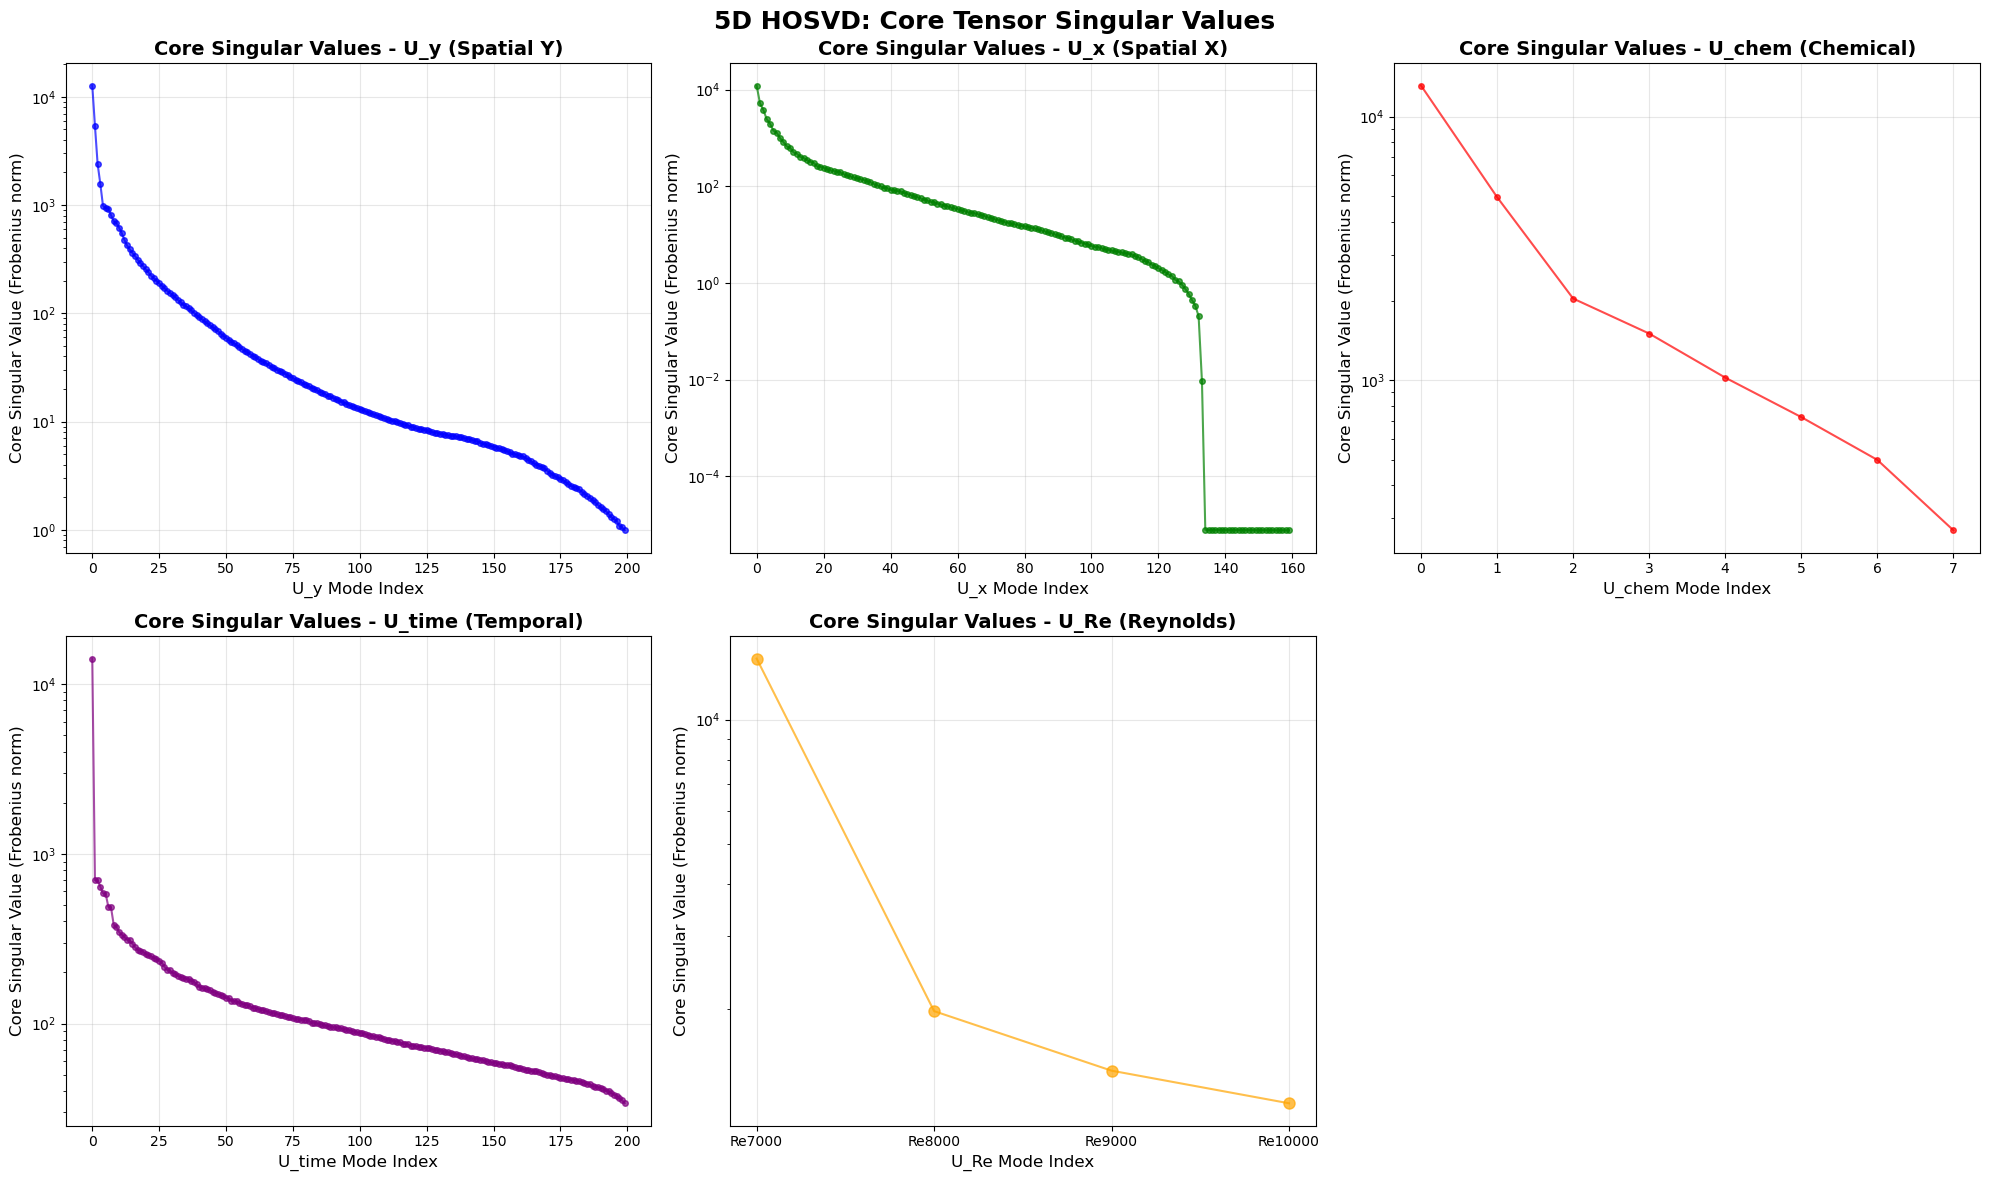

In [9]:
# Visualize core singular values for all 5 modes
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# U_y (Spatial Y)
sv_y = [np.linalg.norm(core[i, :, :, :, :]) for i in range(core.shape[0])]
ax = axes[0, 0]
ax.plot(range(len(sv_y)), sv_y, 'o-', color='blue', alpha=0.7, markersize=4)
ax.set_xlabel('U_y Mode Index', fontsize=12)
ax.set_ylabel('Core Singular Value (Frobenius norm)', fontsize=12)
ax.set_title('Core Singular Values - U_y (Spatial Y)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# U_x (Spatial X)
sv_x = [np.linalg.norm(core[:, i, :, :, :]) for i in range(core.shape[1])]
ax = axes[0, 1]
ax.plot(range(len(sv_x)), sv_x, 'o-', color='green', alpha=0.7, markersize=4)
ax.set_xlabel('U_x Mode Index', fontsize=12)
ax.set_ylabel('Core Singular Value (Frobenius norm)', fontsize=12)
ax.set_title('Core Singular Values - U_x (Spatial X)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# U_chem (Chemical)
sv_chem = [np.linalg.norm(core[:, :, i, :, :]) for i in range(core.shape[2])]
ax = axes[0, 2]
ax.plot(range(len(sv_chem)), sv_chem, 'o-', color='red', alpha=0.7, markersize=4)
ax.set_xlabel('U_chem Mode Index', fontsize=12)
ax.set_ylabel('Core Singular Value (Frobenius norm)', fontsize=12)
ax.set_title('Core Singular Values - U_chem (Chemical)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# U_time (Temporal)
sv_time = [np.linalg.norm(core[:, :, :, i, :]) for i in range(core.shape[3])]
ax = axes[1, 0]
ax.plot(range(len(sv_time)), sv_time, 'o-', color='purple', alpha=0.7, markersize=4)
ax.set_xlabel('U_time Mode Index', fontsize=12)
ax.set_ylabel('Core Singular Value (Frobenius norm)', fontsize=12)
ax.set_title('Core Singular Values - U_time (Temporal)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# U_Re (Reynolds)
sv_re = [np.linalg.norm(core[:, :, :, :, i]) for i in range(core.shape[4])]
ax = axes[1, 1]
ax.plot(range(len(sv_re)), sv_re, 'o-', color='orange', alpha=0.7, markersize=8)
ax.set_xlabel('U_Re Mode Index', fontsize=12)
ax.set_ylabel('Core Singular Value (Frobenius norm)', fontsize=12)
ax.set_title('Core Singular Values - U_Re (Reynolds)', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(reynolds_numbers)))
ax.set_xticklabels([f'Re{re}' for re in reynolds_numbers])
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Hide the last unused subplot
axes[1, 2].axis('off')

fig.suptitle('5D HOSVD: Core Tensor Singular Values', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

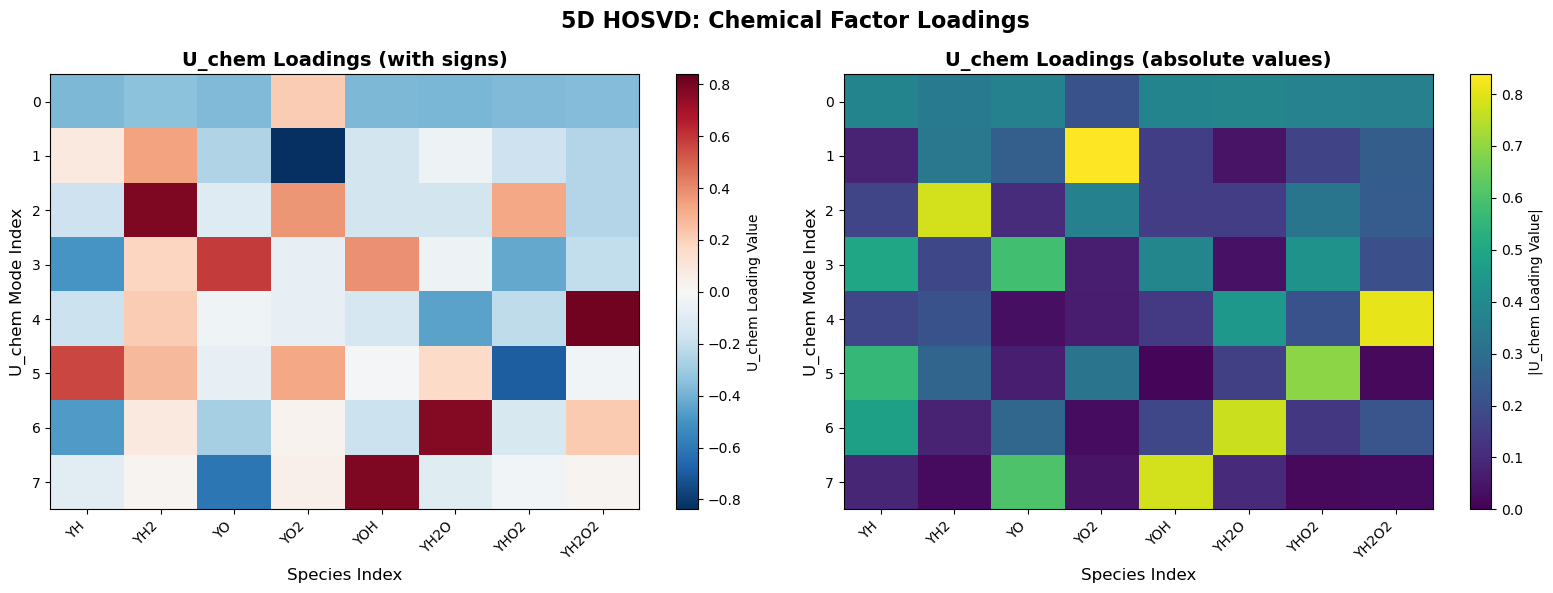

In [10]:
# Visualize U_chem loadings
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# With signs
ax = axes[0]
im0 = ax.imshow(U_chem.T, cmap='RdBu_r', aspect='auto', 
                vmin=-np.abs(U_chem).max(), vmax=np.abs(U_chem).max())
ax.set_xlabel('Species Index', fontsize=12)
ax.set_ylabel('U_chem Mode Index', fontsize=12)
ax.set_title('U_chem Loadings (with signs)', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(component_names)))
ax.set_xticklabels(component_names, rotation=45, ha='right')
plt.colorbar(im0, ax=ax, label='U_chem Loading Value')

# Absolute values
ax = axes[1]
im1 = ax.imshow(np.abs(U_chem).T, cmap='viridis', aspect='auto', 
                vmin=0, vmax=np.abs(U_chem).max())
ax.set_xlabel('Species Index', fontsize=12)
ax.set_ylabel('U_chem Mode Index', fontsize=12)
ax.set_title('U_chem Loadings (absolute values)', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(component_names)))
ax.set_xticklabels(component_names, rotation=45, ha='right')
plt.colorbar(im1, ax=ax, label='|U_chem Loading Value|')

fig.suptitle('5D HOSVD: Chemical Factor Loadings', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

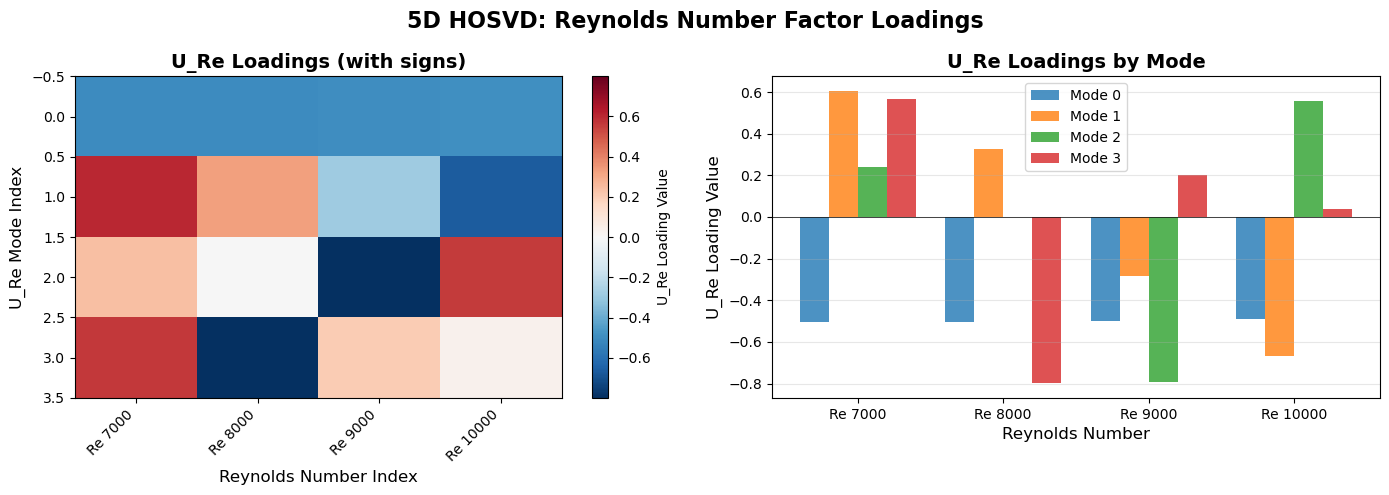

In [11]:
# Visualize U_Re loadings (Reynolds number factor)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap
ax = axes[0]
im = ax.imshow(U_Re.T, cmap='RdBu_r', aspect='auto',
               vmin=-np.abs(U_Re).max(), vmax=np.abs(U_Re).max())
ax.set_xlabel('Reynolds Number Index', fontsize=12)
ax.set_ylabel('U_Re Mode Index', fontsize=12)
ax.set_title('U_Re Loadings (with signs)', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(reynolds_numbers)))
ax.set_xticklabels([f'Re {re}' for re in reynolds_numbers], rotation=45, ha='right')
plt.colorbar(im, ax=ax, label='U_Re Loading Value')

# Bar plot for each mode
ax = axes[1]
x = np.arange(len(reynolds_numbers))
width = 0.2
for mode_idx in range(U_Re.shape[1]):
    values = U_Re[:, mode_idx]
    ax.bar(x + mode_idx*width, values, width, label=f'Mode {mode_idx}', alpha=0.8)

ax.set_xlabel('Reynolds Number', fontsize=12)
ax.set_ylabel('U_Re Loading Value', fontsize=12)
ax.set_title('U_Re Loadings by Mode', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * (U_Re.shape[1]-1) / 2)
ax.set_xticklabels([f'Re {re}' for re in reynolds_numbers])
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

fig.suptitle('5D HOSVD: Reynolds Number Factor Loadings', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

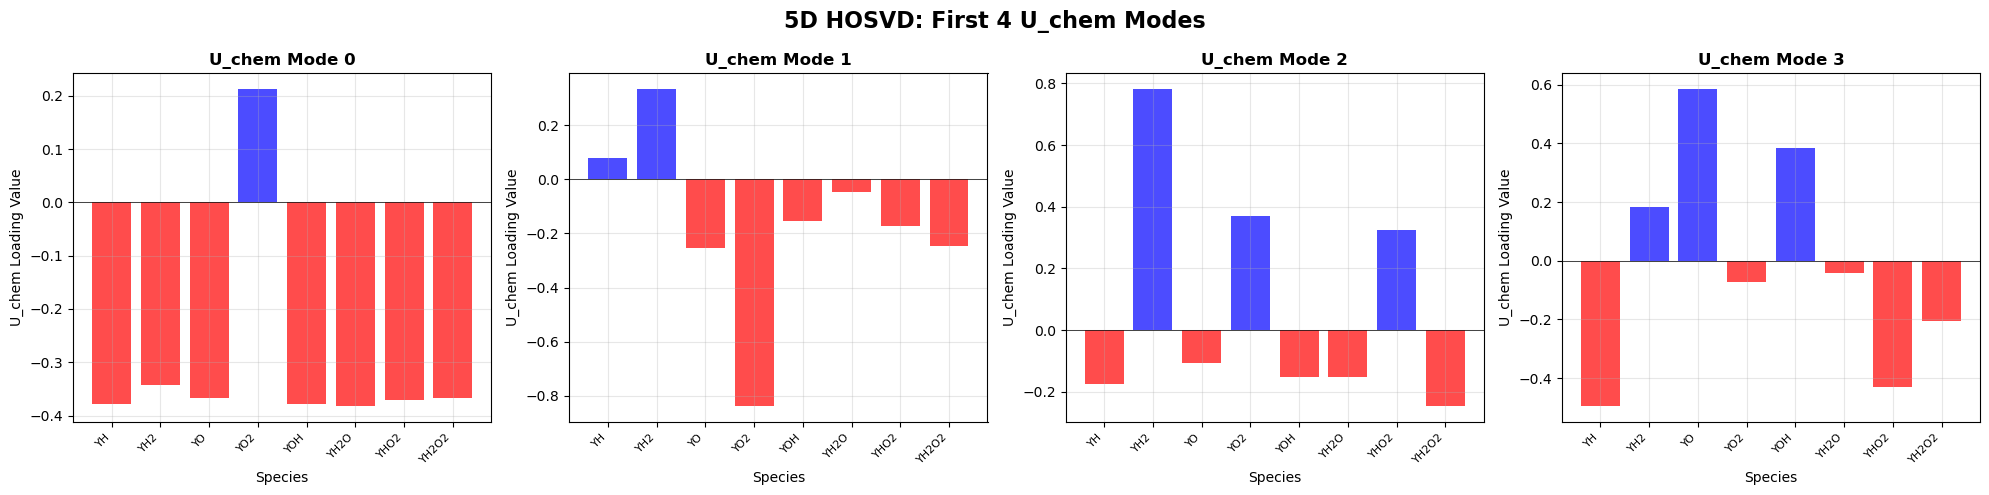

In [12]:
# Visualize first few U_chem modes as bar plots
n_modes_to_show = min(4, U_chem.shape[1])

fig, axes = plt.subplots(1, n_modes_to_show, figsize=(20, 5))

x = np.arange(len(component_names))

for mode_idx in range(n_modes_to_show):
    ax = axes[mode_idx] if n_modes_to_show > 1 else axes
    values = U_chem[:, mode_idx]
    colors = ['red' if v < 0 else 'blue' for v in values]
    ax.bar(x, values, color=colors, alpha=0.7)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('Species', fontsize=10)
    ax.set_ylabel('U_chem Loading Value', fontsize=10)
    ax.set_title(f'U_chem Mode {mode_idx}', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(component_names, rotation=45, ha='right', fontsize=8)
    ax.grid(True, alpha=0.3)

fig.suptitle(f'5D HOSVD: First {n_modes_to_show} U_chem Modes', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

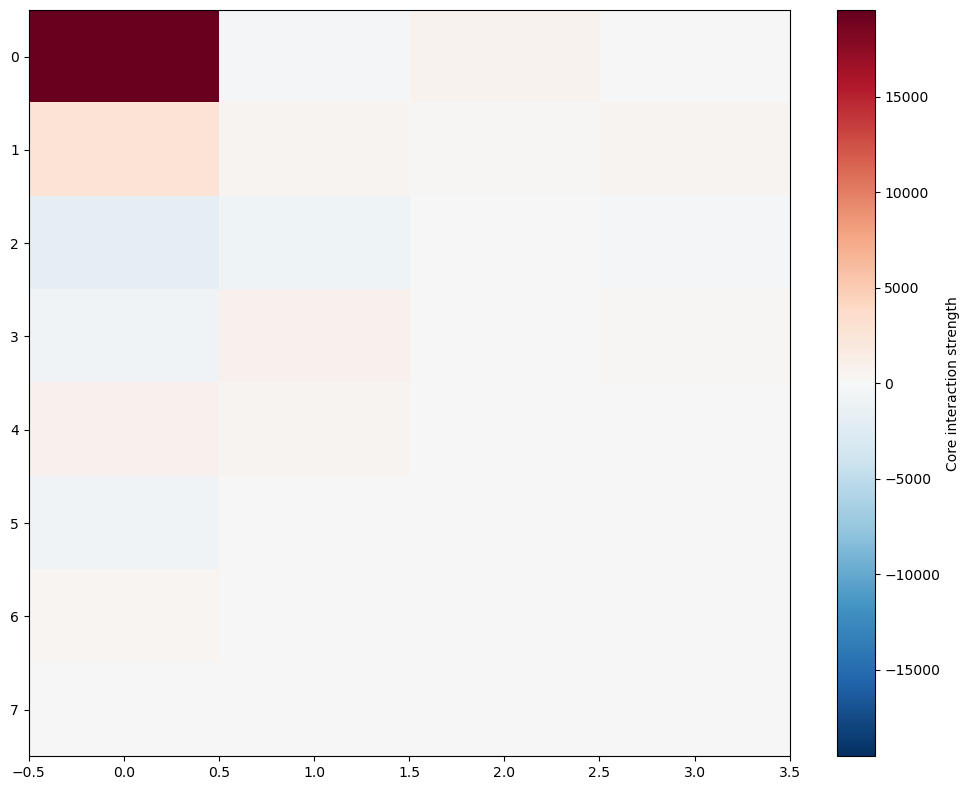

In [21]:


spatial_coupling = np.sum(core, axis=(0,1, 3))[:10, :20]

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

im = ax.imshow(spatial_coupling, cmap='RdBu_r', aspect='auto',
               vmin=-np.abs(spatial_coupling).max(),
               vmax=np.abs(spatial_coupling).max())
plt.colorbar(im, ax=ax, label='Core interaction strength')

plt.tight_layout()
plt.show()